# Project: Investigate a Dataset (No-Show Appointments)

- This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
    - ‘ScheduledDay’ tells us on what day the patient set up their appointment.
    - ‘Neighborhood’ indicates the location of the hospital.
    - ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
    - Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.
    
    
- **The Questions We Want to Answer is**:
    - What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

- Data wrangling consists of three phases and the whole process are iterative in any phase:
    - Gathering data.
    - Assessing data.
    - Cleaning data.

### 1.Gathering Data
### Load noshowappointments.csv 

In [2]:
appoints_df = pd.read_csv('datasets/noshowappointments.csv')

### 2.Assessing Data
- get info , stats about data

### findings:
- Interseting Columns are ['Gender', 'ScheduledDay','AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']

- 'PatientId', 'AppointmentID' are identifiers columns for patient and appointment  and should be dropped.

- 'ScheduledDay','AppointmentDay' are strings and should be of type datetime.

- 'Age' column has 1 entry with value -1 (could be removed) and 3539 entry with value 0 (newborn).

- 'Scholarship', 'Hipertension','Diabetes', 'Alcoholism', 'SMS_received', 'No-show' are integers and should be of type boolean

In [3]:
appoints_df.sample(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
53554,4.678419e+13,5670819,M,2016-05-06T14:43:50Z,2016-05-06T00:00:00Z,15,MARUÍPE,0,0,0,0,0,0,No
40476,8.164327e+12,5529726,F,2016-03-31T07:34:21Z,2016-05-12T00:00:00Z,21,JOANA D´ARC,0,0,0,0,0,1,Yes
72021,8.832582e+12,5677985,M,2016-05-10T07:54:24Z,2016-05-12T00:00:00Z,12,RESISTÊNCIA,0,0,0,0,0,0,No
38995,7.916721e+12,5642591,M,2016-04-29T16:25:50Z,2016-05-03T00:00:00Z,46,MARUÍPE,0,0,0,0,0,1,No
71229,4.752360e+12,5443599,F,2016-03-08T13:10:02Z,2016-05-17T00:00:00Z,59,CENTRO,0,0,0,0,0,0,Yes


In [4]:
appoints_df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [5]:
appoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [6]:
appoints_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [7]:
#check duplicates in data

appoints_df.duplicated().sum()

0

In [8]:
#check missing values in data

appoints_df.isnull().sum().sum()

0

In [9]:
#findings for columns : 'Gender'

print(appoints_df['Gender'].value_counts(dropna=False))
print(appoints_df['Gender'].dtype)

F    71840
M    38687
Name: Gender, dtype: int64
object


In [10]:
#findings for columns : 'ScheduledDay','AppointmentDay'

#print(appoints_df['ScheduledDay'].value_counts(dropna=False)).sort_index()
print('Min Scheduled Day: {}'.format(appoints_df['ScheduledDay'].min()))
print('Max Scheduled Day: {}'.format(appoints_df['ScheduledDay'].max()))
print('No. of Unique Scheduled Days: {}'.format(appoints_df['ScheduledDay'].nunique()))
print('Type of Scheduled Day Column : {}'.format(appoints_df['ScheduledDay'].dtype))

#print(appoints_df['AppointmentDay'].value_counts(dropna=False)).sort_index()
print('Min Appointment Day: {}'.format(appoints_df['AppointmentDay'].min()))
print('Max Appointment Day: {}'.format(appoints_df['AppointmentDay'].max()))
print('No. of Unique Appointment Days: {}'.format(appoints_df['AppointmentDay'].nunique()))
print('Type of Appointment Day Column : {}'.format(appoints_df['AppointmentDay'].dtype))

Min Scheduled Day: 2015-11-10T07:13:56Z
Max Scheduled Day: 2016-06-08T20:07:23Z
No. of Unique Scheduled Days: 103549
Type of Scheduled Day Column : object
Min Appointment Day: 2016-04-29T00:00:00Z
Max Appointment Day: 2016-06-08T00:00:00Z
No. of Unique Appointment Days: 27
Type of Appointment Day Column : object


In [11]:
#findings for columns : 'Age'

print(appoints_df['Age'].value_counts(dropna=False).sort_index())
print(appoints_df['Age'].dtype)

-1         1
 0      3539
 1      2273
 2      1618
 3      1513
        ... 
 98        6
 99        1
 100       4
 102       2
 115       5
Name: Age, Length: 104, dtype: int64
int64


In [12]:
#findings for columns : 'Neighbourhood'

print(appoints_df['Neighbourhood'].value_counts(dropna=False))
print(appoints_df['Neighbourhood'].dtype)

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64
object


In [13]:
#findings for columns : 'Handcap'

print(appoints_df['Handcap'].value_counts(dropna=False))
print(appoints_df['Handcap'].dtype)

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64
int64


In [14]:
#findings for columns : 'Scholarship', 'Hipertension','Diabetes', 'Alcoholism',  'SMS_received', 'No-show'

print(appoints_df['Scholarship'].value_counts(dropna=False))
print(appoints_df['Scholarship'].dtype)

print(appoints_df['Hipertension'].value_counts(dropna=False))
print(appoints_df['Hipertension'].dtype)

print(appoints_df['Diabetes'].value_counts(dropna=False))
print(appoints_df['Diabetes'].dtype)

print(appoints_df['SMS_received'].value_counts(dropna=False))
print(appoints_df['SMS_received'].dtype)

print(appoints_df['No-show'].value_counts(dropna=False))
print(appoints_df['No-show'].dtype)

0    99666
1    10861
Name: Scholarship, dtype: int64
int64
0    88726
1    21801
Name: Hipertension, dtype: int64
int64
0    102584
1      7943
Name: Diabetes, dtype: int64
int64
0    75045
1    35482
Name: SMS_received, dtype: int64
int64
No     88208
Yes    22319
Name: No-show, dtype: int64
object


### 3.Data Cleaning 

#### work on copy of the original data frame

In [15]:
appoints_clean = appoints_df.copy()

### Drop unneeded columns

### Define
- 'PatientId', 'AppointmentID' are identifiers columns for patient and appointment  and should be dropped.

### Code

In [16]:
appoints_clean.drop(['PatientId', 'AppointmentID'],axis=1,inplace=True);

### Test

In [17]:
appoints_clean.columns

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show'],
      dtype='object')

### Erroneous datatypes

### Define
- 'ScheduledDay','AppointmentDay' are strings and should be of type datetime.
- 'Scholarship', 'Hipertension','Diabetes', 'Alcoholism', 'SMS_received', 'No-show' are integers and should be of type boolean

### Code

In [18]:
# converting ScheduledDay,AppointmentDay to datetime column
appoints_clean['ScheduledDay'] = pd.to_datetime(appoints_clean['ScheduledDay'], errors='coerce')
appoints_clean['AppointmentDay'] = pd.to_datetime(appoints_clean['AppointmentDay'], errors='coerce')

# mapping values in No-show columns to 0 (attended appointment), 1 (missed appointment) to be converted to bool
appoints_clean['No-show'] = appoints_clean['No-show'].map({
    'No':0,
    'Yes':1
}).astype(bool)

# concverting Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received to bool
bool_columns = ['Scholarship', 'Hipertension','Diabetes', 'Alcoholism', 'SMS_received']
appoints_clean[bool_columns] = appoints_clean[bool_columns].astype(bool)

### Test

In [19]:
appoints_clean.dtypes

Gender                         object
ScheduledDay      datetime64[ns, UTC]
AppointmentDay    datetime64[ns, UTC]
Age                             int64
Neighbourhood                  object
Scholarship                      bool
Hipertension                     bool
Diabetes                         bool
Alcoholism                       bool
Handcap                         int64
SMS_received                     bool
No-show                          bool
dtype: object

### Define
- 'Age' column has 1 entry with value -1 

### Code


In [20]:
row_index = appoints_clean[appoints_clean['Age']== -1].index
appoints_clean.drop(index=row_index,inplace=True)

### Test

In [21]:
appoints_clean[appoints_clean['Age']== -1]

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


### Save Cleaned Data

In [22]:
appoints_clean.to_csv('datasets/noshowappointments_cleaned.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis


In [23]:
#make masks for attend , missed conditions

attended = appoints_clean['No-show']==False
missed = appoints_clean['No-show']==True

### Research Question

### checking the percentage of appointments attended vs missed
- the percentage of attending the appointment is way higher than missing it

In [24]:
appoints_clean['No-show'].value_counts(normalize=True)*100

False    79.806561
True     20.193439
Name: No-show, dtype: float64

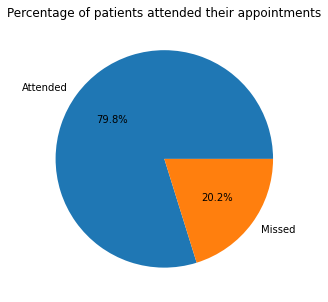

In [25]:
appoints_clean['No-show'].value_counts(normalize=True).plot.pie(figsize=(5,5) ,labels=['Attended','Missed'], autopct='%.1f%%' , title="Percentage of patients attended their appointments");
plt.ylabel('');

### Research Question

### checking the percentage of Female vs Male
- it will help to better understand the if gender affects the No-show
- females in dataset are bout 65% and males are about 35%

In [26]:
appoints_clean['Gender'].value_counts(normalize=True)*100

F    64.997376
M    35.002624
Name: Gender, dtype: float64

### Research Question

### It seems that Gender has not effect on appointment attendance percentage
- missing percentage and attending percentage for females and males are almost the same of females and males percentage in the dataset

In [27]:
print(appoints_clean.loc[attended , 'Gender'].value_counts(normalize=True)*100)
print(appoints_clean.loc[missed , 'Gender'].value_counts(normalize=True)*100)

F    64.898477
M    35.101523
Name: Gender, dtype: float64
F    65.388234
M    34.611766
Name: Gender, dtype: float64


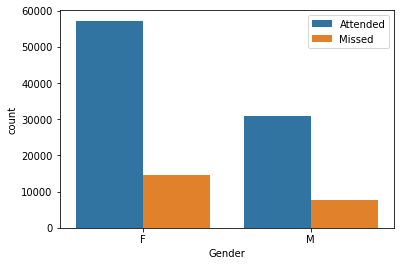

In [28]:
sns.countplot(x = 'Gender', hue = 'No-show', data = appoints_clean);
plt.legend(['Attended','Missed']);

### Research Question

### It seems that age has no correlation with attending the appointments
- distribution for attending and missing appointments are similar when grouping by age-category and No-show
- age category (100-110) has rate 100% on showing for their appointments but their were only 6 patients in this category

In [29]:
print(appoints_clean['Age'].value_counts().sort_values(ascending=False))
print(appoints_clean['Age'].describe())

0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
98        6
115       5
100       4
102       2
99        1
Name: Age, Length: 103, dtype: int64
count    110526.000000
mean         37.089219
std          23.110026
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64


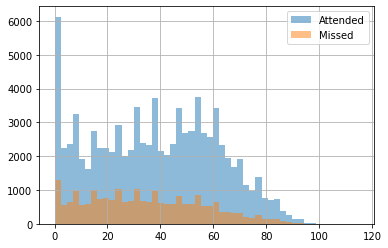

In [30]:
appoints_clean.loc[attended ,'Age'].hist(alpha=0.5,bins=50,label='Attended');
appoints_clean.loc[missed ,'Age'].hist(alpha=0.5,bins=50,label='Missed');
plt.legend();

In [31]:
bins=[0, 10, 20,30,40,50,60,70,80,90,100,110,120]
labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110','110-120']
appoints_clean['Age_category'] = pd.cut(appoints_clean['Age'],bins=bins , include_lowest=True,labels = labels )

In [32]:
appoints_clean.groupby('Age_category')['No-show'].value_counts(normalize=True)*100

Age_category  No-show
0-10          False       79.796256
              True        20.203744
10-20         False       74.746164
              True        25.253836
20-30         False       75.375463
              True        24.624537
30-40         False       78.527770
              True        21.472230
40-50         False       80.097087
              True        19.902913
50-60         False       82.625631
              True        17.374369
60-70         False       85.271249
              True        14.728751
70-80         False       84.460759
              True        15.539241
80-90         False       84.001572
              True        15.998428
90-100        False       80.398671
              True        19.601329
100-110       False      100.000000
110-120       True        60.000000
              False       40.000000
Name: No-show, dtype: float64

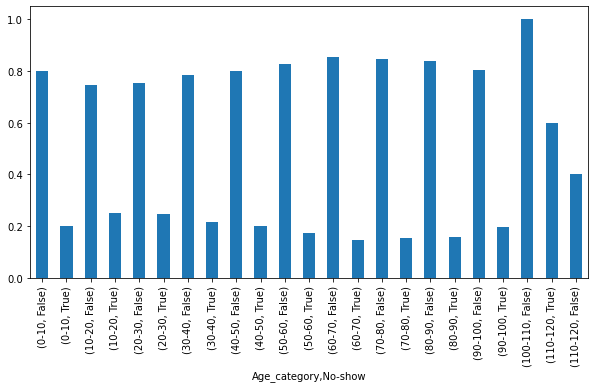

In [33]:
#appoints_clean.groupby(['Age_category','No-show'])['No-show'].count().plot(kind='bar',figsize=(10,5))
appoints_clean.groupby('Age_category')['No-show'].value_counts(normalize=True).plot.bar(figsize=(10,5));

In [34]:
appoints_clean.loc[(appoints_clean['Age']>=100) & (appoints_clean['Age']<110),['Age','No-show']]

,Age,No-show
58014,102,False
79270,100,False
79272,100,False
90372,102,False
92084,100,False
108506,100,False


### Research Question

### It seems that Handcap has positive correlation with No-show 'missing' the appointments

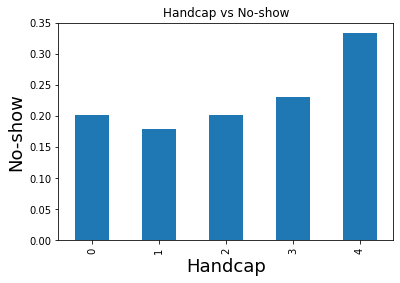

In [35]:
handcap_plot =appoints_clean.groupby('Handcap')['No-show'].mean()

plt.title('Handcap vs No-show')
plt.xlabel('Handcap',fontsize=18)
plt.ylabel('No-show',fontsize=18);
handcap_plot.plot(kind='bar');

### Research Question

### It seems that registering in the Scholarship program has no such great effect in making patients attend the appointments

### It seems also that Hipertension,Diabetes,Alcoholism don't affect in No show

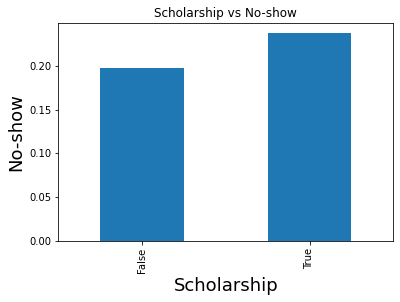

In [36]:
scolarship_plot = appoints_clean.groupby('Scholarship')['No-show'].mean()

plt.title('Scholarship vs No-show')
plt.xlabel('Scholarship',fontsize=18)
plt.ylabel('No-show',fontsize=18);
scolarship_plot.plot(kind='bar');

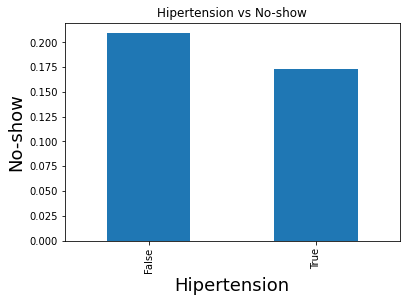

In [37]:
hipertension_plot =appoints_clean.groupby('Hipertension')['No-show'].mean()

plt.title('Hipertension vs No-show')
plt.xlabel('Hipertension',fontsize=18)
plt.ylabel('No-show',fontsize=18);
hipertension_plot.plot(kind='bar');

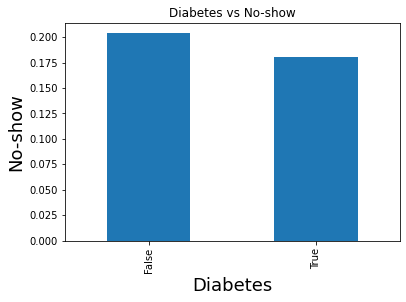

In [38]:
diabetes_plot =appoints_clean.groupby('Diabetes')['No-show'].mean()

plt.title('Diabetes vs No-show')
plt.xlabel('Diabetes',fontsize=18)
plt.ylabel('No-show',fontsize=18);
diabetes_plot.plot(kind='bar');

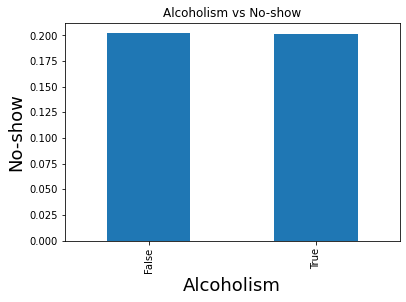

In [39]:
alcoholism_plot =appoints_clean.groupby('Alcoholism')['No-show'].mean()

plt.title('Alcoholism vs No-show')
plt.xlabel('Alcoholism',fontsize=18)
plt.ylabel('No-show',fontsize=18);
alcoholism_plot.plot(kind='bar');

### Research Question

### Does Sending SMS increases the percentage of attending the appointments ??
- It seems that SMS does not have great effect in making patients attend their appointments

In [40]:
appoints_clean['SMS_received'].value_counts(normalize=True)*100

False    67.897146
True     32.102854
Name: SMS_received, dtype: float64

In [41]:
print(appoints_clean.loc[attended , 'SMS_received'].value_counts(normalize=True)*100)
print(appoints_clean.loc[missed , 'SMS_received'].value_counts(normalize=True)*100)

False    70.866258
True     29.133742
Name: SMS_received, dtype: float64
False    56.162911
True     43.837089
Name: SMS_received, dtype: float64


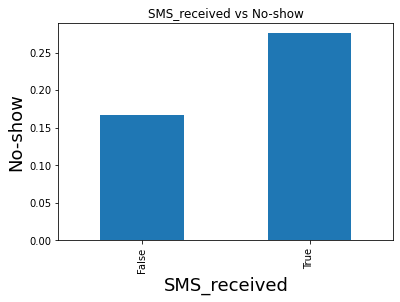

In [42]:
sms_plot =appoints_clean.groupby('SMS_received')['No-show'].mean()

plt.title('SMS_received vs No-show')
plt.xlabel('SMS_received',fontsize=18)
plt.ylabel('No-show',fontsize=18);
sms_plot.plot(kind='bar');

### Research Question

### Does waiting days between scheduled and appointment day affect the percentage of attending the appointments ??
- AppointmentDay column doesn't have hour info so we could consider -1 as the same day
- for entries with -2,-7 , I will drop them
- **It seems that the waiting days have segnificant impact in attending the appointment **
- **increasing the waiting days between scheduled day and appointment day leads to a higher percentage for No-show**

In [43]:
appoints_clean['waiting_days'] =(appoints_clean['AppointmentDay'] - appoints_clean['ScheduledDay']).dt.days

In [44]:
print(appoints_clean['waiting_days'].value_counts().sort_index())
print(appoints_clean['waiting_days'].describe())

-7          1
-2          4
-1      38562
 0       5213
 1       6725
        ...  
 154       10
 161       11
 168        8
 175       16
 178       10
Name: waiting_days, Length: 131, dtype: int64
count    110526.000000
mean          9.183794
std          15.255034
min          -7.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: waiting_days, dtype: float64


In [45]:
appoints_clean[appoints_clean['waiting_days'] < -1]

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Age_category,waiting_days
27033,M,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,False,False,False,False,1,False,True,30-40,-2
55226,F,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,False,False,False,False,1,False,True,10-20,-2
64175,F,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,False,False,False,False,0,False,True,20-30,-2
71533,F,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,False,False,False,False,0,False,True,80-90,-7
72362,M,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,False,False,False,False,0,False,True,0-10,-2


In [46]:
appoints_clean[appoints_clean['waiting_days'] <= 0 ]

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Age_category,waiting_days
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,False,True,False,False,0,False,False,60-70,-1
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,False,False,False,0,False,False,50-60,-1
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,False,False,False,False,0,False,False,60-70,-1
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,False,False,False,False,0,False,False,0-10,-1
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,True,True,False,0,False,False,50-60,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110512,F,2016-06-08 08:20:01+00:00,2016-06-08 00:00:00+00:00,41,MARIA ORTIZ,False,False,False,False,0,False,False,40-50,-1
110513,M,2016-06-08 07:52:55+00:00,2016-06-08 00:00:00+00:00,2,ANTÔNIO HONÓRIO,False,False,False,False,0,False,False,0-10,-1
110514,F,2016-06-08 08:35:31+00:00,2016-06-08 00:00:00+00:00,58,MARIA ORTIZ,False,False,False,False,0,False,False,50-60,-1
110516,F,2016-06-07 07:45:16+00:00,2016-06-08 00:00:00+00:00,37,MARIA ORTIZ,False,False,False,False,0,False,True,30-40,0


In [47]:
def clean_waiting_days(value):
    if value == -2 or value == -7:
        print(value)
        return np.nan
    elif value == -1 :
        return 0
    else:
        return value

print('Before : {}'.format(appoints_clean.shape))
appoints_clean['waiting_days']  = appoints_clean['waiting_days'].replace(-2,np.nan).replace(-7,np.nan).replace(-1,0)
appoints_clean.dropna(inplace=True)
print('After : {}'.format(appoints_clean.shape))

Before : (110526, 14)
After : (110521, 14)


In [48]:
appoints_clean['waiting_days'].value_counts()

0.0      43775
1.0       6725
3.0       5290
6.0       4906
5.0       4037
         ...  
81.0         1
116.0        1
131.0        1
126.0        1
124.0        1
Name: waiting_days, Length: 128, dtype: int64

In [49]:
appoints_clean.groupby('waiting_days')['No-show'].value_counts(normalize=True).sort_index()[:10]*100

waiting_days  No-show
0.0           False      93.363792
              True        6.636208
1.0           False      76.178439
              True       23.821561
2.0           False      76.470588
              True       23.529412
3.0           False      76.729679
              True       23.270321
4.0           False      73.390296
              True       26.609704
Name: No-show, dtype: float64

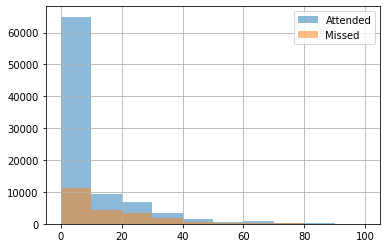

In [50]:
appoints_clean.loc[attended ,'waiting_days'].hist(alpha=0.5,range=[0,100],label='Attended');
appoints_clean.loc[missed ,'waiting_days'].hist(alpha=0.5,range=[0,100],label='Missed');
plt.legend();

<a id='conclusions'></a>
## Conclusions

- Gender has not effect on showing for schedualed appointment.
- Age also has no clear correlation with attending the appointments.
- Handcap has positive correlation with No-show 'missing' the appointments.
- It seems that registering in the Scholarship program has no such great effect in making patients attend the appointments.
- Sending SMS, unlike expected, don't increase the percentage of attending the appointments.
- It seems also that Hipertension,Diabetes,Alcoholism don't affect in No show percentage.
- increasing the waiting days between scheduled day and appointment day leads to a higher percentage for No-show.